<style>
    .zero-margin {
        margin: 0 px;
     }
</style>

<div class="zero-margin" style="text-align: center;">
    <p style="text-align: center; font-size: 20px; margin-bottom: 10px;">Practice Case 04<p>
    <p style="text-align: center; font-size: 40px; margin: 0px; font-weight: bold;text-transform: uppercase;">Machine Learning</p><br/>
    <p  style="text-align: center; margin-bottom: 0px;">Monday, November 4th 2019</p>
     <p  style="text-align: center; margin-top: 0px;">M. Haries Ramdhani</p>
</div>

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit

pd.options.display.max_columns = 50
import warnings
warnings.filterwarnings("ignore")

In [2]:
from bs4 import BeautifulSoup as bs
import requests
import re
import time

In [3]:
df = pd.read_csv("../data/flight/training_dataset.csv")
df_test = pd.read_csv("../data/flight/test_dataset.csv")

In [4]:
# Flag the test and train data so it can be easily distinguished in the future
df_test["flag_test"] = 1
df["flag_test"] = 0

In [5]:
df = df.append(df_test)

In [6]:
# Preview of the data frame
df.head()

,id,number,airline,airline_name,scheduled_departure_time,scheduled_arrival_time,departure_airport_city,departure_airport_code,departure_airport_country,departure_airport_gate,departure_airport_name,departure_airport_region,departure_airport_terminal,departure_airport_timezone,arrival_airport_city,arrival_airport_code,arrival_airport_country,arrival_airport_gate,arrival_airport_name,arrival_airport_region,arrival_airport_terminal,arrival_airport_timezone,flight_equipment_iata,flight_equipment_name,flight_duration,delay,flag_test
0,1,AK6430,AK,AirAsia,2018-10-05 22:00:00,2018-10-05 23:05:00,Kuala Lumpur,KUL,MY,J15,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Kota Bharu,KBR,MY,2,Sultan Ismail Petra Airport,Asia,NaN,Asia/Kuala_Lumpur,32S,Airbus A318 / A319 / A320 / A321,58m,2,0
1,2,ID*7164,ID*,Batik Air,2018-10-05 22:00:00,2018-10-05 23:55:00,Kuala Lumpur,KUL,MY,C33,Kuala Lumpur International Airport,Asia,M,Asia/Kuala_Lumpur,Jakarta,CGK,ID,5,Soekarno-Hatta International Airport,Asia,2,Asia/Jakarta,32S,Airbus A318 / A319 / A320 / A321,1h 55m,8,0
2,3,MXD9116,MXD,Malindo Air,2018-10-05 22:00:00,2018-10-05 23:55:00,Kuala Lumpur,KUL,MY,C33,Kuala Lumpur International Airport,Asia,M,Asia/Kuala_Lumpur,Jakarta,CGK,ID,5,Soekarno-Hatta International Airport,Asia,2,Asia/Jakarta,32S,Airbus A318 / A319 / A320 / A321,1h 55m,8,0
3,4,AK5198,AK,AirAsia,2018-10-05 22:05:00,2018-10-06 01:00:00,Kuala Lumpur,KUL,MY,J9,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Sandakan,SDK,MY,INT,Sandakan Airport,Asia,NaN,Asia/Kuala_Lumpur,32S,Airbus A318 / A319 / A320 / A321,2h 54m,0,0
4,5,AK516,AK,AirAsia,2018-10-05 22:10:00,2018-10-06 01:25:00,Kuala Lumpur,KUL,MY,P1,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Hanoi,HAN,VN,NaN,Noi Bai International Airport,Asia,T2,Asia/Ho_Chi_Minh,32S,Airbus A318 / A319 / A320 / A321,3h 17m,0,0


In [7]:
# gives some infos on columns types and number of null values
df_info = pd.DataFrame(df.dtypes).rename(columns={0:'data_type'})
df_info["#_unique"] = df.nunique()
df_info["#_nan"] = df.isnull().sum().astype(int)
df_info["%_nan"] = df.isnull().sum()/df.shape[0]*100

df_info.sort_values(by="#_unique", ascending=False)

,data_type,#_unique,#_nan,%_nan
id,int64,152625,0,0.000000
scheduled_arrival_time,object,19159,7,0.004586
scheduled_departure_time,object,17499,0,0.000000
number,object,2590,0,0.000000
flight_duration,object,723,5,0.003276
delay,int64,379,0,0.000000
arrival_airport_gate,object,284,137275,89.942670
departure_airport_gate,object,189,60619,39.717609
arrival_airport_name,object,157,0,0.000000
arrival_airport_code,object,157,0,0.000000


Looking at the DataFrame above we got these insights:
1. `scheduled_arrival_time` and `scheduled_departure_time` have to be converted into time format
2. `arrival_airport_gate`, `arrival_airport_terminal`, `departure_airport_gate`, `departure_airport_terminal` contain the most missing values, this can be caused by the fact that the passengers aren't tracked based on the gates and terminals. Percentages of their missing values are very high (would be nice if it can be dropped).
3. `flight_duration` is still in the object (string) type. It needs to be converted to `int`, in this case to minutes
4. `departure_airport_region`, `departure_airport_country` and `departure_airport_timezone` only contain 1 unique value, so we can safely drop them
5. We can also scrape the flight distance data from another website to get the distance between the two airports

## Feature Engineering

### Get Scheduled Flight Duration
Get the scheduled flight duration from the ticket. This is calculated by substracting the `scheduled_arrival_date` and `scheduled_departure_date`<br/><br/> 
**ASSUMPTION**: `scheduled_flight_duration` might have something to do with the delay because it can be used to calculate the velocity of the airplane by dividing the `distance` with the `scheduled_flight_duration`, the slower the velocity of the airplane compared to the normal ones may cause the flight come later than its supposed to.


#### Convert the time data to time objects

In [8]:
df["scheduled_departure_time"] = pd.to_datetime(df["scheduled_departure_time"]) 
df["scheduled_arrival_time"] = pd.to_datetime(df["scheduled_arrival_time"])

In [9]:
df["scheduled_flight_duration"] = df["scheduled_arrival_time"] - df["scheduled_departure_time"]
df["scheduled_flight_duration"] = df["scheduled_flight_duration"].dt.components['hours'] * 60 + df["scheduled_flight_duration"].dt.components['minutes']

In [10]:
df.head()

,id,number,airline,airline_name,scheduled_departure_time,scheduled_arrival_time,departure_airport_city,departure_airport_code,departure_airport_country,departure_airport_gate,departure_airport_name,departure_airport_region,departure_airport_terminal,departure_airport_timezone,arrival_airport_city,arrival_airport_code,arrival_airport_country,arrival_airport_gate,arrival_airport_name,arrival_airport_region,arrival_airport_terminal,arrival_airport_timezone,flight_equipment_iata,flight_equipment_name,flight_duration,delay,flag_test,scheduled_flight_duration
0,1,AK6430,AK,AirAsia,2018-10-05 22:00:00,2018-10-05 23:05:00,Kuala Lumpur,KUL,MY,J15,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Kota Bharu,KBR,MY,2,Sultan Ismail Petra Airport,Asia,NaN,Asia/Kuala_Lumpur,32S,Airbus A318 / A319 / A320 / A321,58m,2,0,65.0
1,2,ID*7164,ID*,Batik Air,2018-10-05 22:00:00,2018-10-05 23:55:00,Kuala Lumpur,KUL,MY,C33,Kuala Lumpur International Airport,Asia,M,Asia/Kuala_Lumpur,Jakarta,CGK,ID,5,Soekarno-Hatta International Airport,Asia,2,Asia/Jakarta,32S,Airbus A318 / A319 / A320 / A321,1h 55m,8,0,115.0
2,3,MXD9116,MXD,Malindo Air,2018-10-05 22:00:00,2018-10-05 23:55:00,Kuala Lumpur,KUL,MY,C33,Kuala Lumpur International Airport,Asia,M,Asia/Kuala_Lumpur,Jakarta,CGK,ID,5,Soekarno-Hatta International Airport,Asia,2,Asia/Jakarta,32S,Airbus A318 / A319 / A320 / A321,1h 55m,8,0,115.0
3,4,AK5198,AK,AirAsia,2018-10-05 22:05:00,2018-10-06 01:00:00,Kuala Lumpur,KUL,MY,J9,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Sandakan,SDK,MY,INT,Sandakan Airport,Asia,NaN,Asia/Kuala_Lumpur,32S,Airbus A318 / A319 / A320 / A321,2h 54m,0,0,175.0
4,5,AK516,AK,AirAsia,2018-10-05 22:10:00,2018-10-06 01:25:00,Kuala Lumpur,KUL,MY,P1,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Hanoi,HAN,VN,NaN,Noi Bai International Airport,Asia,T2,Asia/Ho_Chi_Minh,32S,Airbus A318 / A319 / A320 / A321,3h 17m,0,0,195.0


### Get Distance Between Two Airports
Get the distance between the departure airport and arrival airport. The data of the distance between the airports is obtained from the website https://www.prokerala.com/travel/airports/distance, the data then scrapped and only the distances between he two airports were taken.<br/><br/>
**ASSUMPTION**: As stated in the previous engineered feature, we're going to try to use the distance together with the flight duration to calculate the velocity of the airplane. *(ignoring the take off and landing time)*

#### Get the Unique Routes
Get only the unique routes since we don't want to perform it repeatedly -> time consuming and web scraping is already taking a long time

In [11]:
route_df = df.drop_duplicates(subset=["departure_airport_code", "arrival_airport_code"])[["departure_airport_code", "arrival_airport_code"]]
route_df.head()

,departure_airport_code,arrival_airport_code
0,KUL,KBR
1,KUL,CGK
3,KUL,SDK
4,KUL,HAN
5,KUL,AOR


Basically what the below codes do is scraping the distance (in km) from prokerala.com using the dataframe of the unique route of the airplane.

In [12]:
# flight_distances = []

# for route in route_df.values:
#     doc = f"https://www.prokerala.com/travel/airports/distance/from-{route[0].lower()}/to-{route[1].lower()}/"

#     response = requests.get(doc, timeout = 10)
#     soup = bs(response.content, "html.parser")

#     content = [element.text for element in soup.find_all('div', {'class': 'tc'})]
    
#     # Check if content contains any values
#     if content:
#         flight_distance_content = content[1]

#         flight_distance = re.findall(r"(\d+(\.\d+)?)", content[1])[1][0]
#         print(flight_distance)
#         flight_distances.append(float(flight_distance))
        
#     else:
#         flight_distances.append(np.nan)
    
#     time.sleep(2)

#### Set the Value and Save it for Later Use

In [13]:
# route_df["distance"] = flight_distances

# route_df.to_csv("route_distance", index=False)

In [14]:
route_df = pd.read_csv("route_distance")

In [15]:
df = pd.merge(df, route_df,  how='left', left_on=["departure_airport_code", "arrival_airport_code"], right_on=["departure_airport_code", "arrival_airport_code"])

### Convert Scheduled Flight Duration to Hour
Get only the hour of how long the flight took place<br/>  
**ASSUMPTION**: Taking the minutes into account is too specific -> it'd be hard for later grouping

In [16]:
df["scheduled_flight_duration_h"] = df["scheduled_flight_duration"].apply(lambda x: x / 60)

### Calculate the Flight Velocity (in km/h)
The flight velocity is calculated by dividing the flight distance with the scheduled_flight_duration

In [17]:
df["flight_velocity"] = df["distance"] / df["scheduled_flight_duration_h"]

### Flag Faster Flight
The feature `flag_faster_flight` tells us whether the airplane flies faster than their counterparts. The flight is called faster if the `flight_velocity` is higher compared to any other planes which flew from the same departure airports to the same arrival airports.<br/>

**ASSUMPTION**: Slower flight may be caused by the transit, if the delay happened during the transit it will eventually affect the following flight delay's probability.

In [28]:
flight_velocity_group_df = df.groupby(["departure_airport_code", "arrival_airport_code", "flight_velocity"]).count()[[]].reset_index()

In [35]:
min_flight_velocity_group_df = flight_velocity_group_df.groupby(["departure_airport_code", "arrival_airport_code"]).min().reset_index().rename(columns={"flight_velocity": "min_flight_velocity"})

In [36]:
flight_velocity_group_df = pd.merge(flight_velocity_group_df, min_flight_velocity_group_df,  how='left', left_on=["departure_airport_code", "arrival_airport_code"], right_on=["departure_airport_code", "arrival_airport_code"])

In [42]:
flight_velocity_group_df["flag_faster_flight"] = (flight_velocity_group_df["flight_velocity"] == flight_velocity_group_df["min_flight_velocity"]).astype(int)

In [45]:
flight_velocity_group_df = flight_velocity_group_df.drop("min_flight_velocity", axis=1)

In [47]:
df = pd.merge(df, flight_velocity_group_df,  how='left', left_on=["departure_airport_code", "arrival_airport_code", "flight_velocity"], right_on=["departure_airport_code", "arrival_airport_code", "flight_velocity"])

In [48]:
df.head()

,id,number,airline,airline_name,scheduled_departure_time,scheduled_arrival_time,departure_airport_city,departure_airport_code,departure_airport_country,departure_airport_gate,departure_airport_name,departure_airport_region,departure_airport_terminal,departure_airport_timezone,arrival_airport_city,arrival_airport_code,arrival_airport_country,arrival_airport_gate,arrival_airport_name,arrival_airport_region,arrival_airport_terminal,arrival_airport_timezone,flight_equipment_iata,flight_equipment_name,flight_duration,delay,flag_test,scheduled_flight_duration,distance,scheduled_flight_duration_h,flight_velocity,flag_faster_flight
0,1,AK6430,AK,AirAsia,2018-10-05 22:00:00,2018-10-05 23:05:00,Kuala Lumpur,KUL,MY,J15,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Kota Bharu,KBR,MY,2,Sultan Ismail Petra Airport,Asia,NaN,Asia/Kuala_Lumpur,32S,Airbus A318 / A319 / A320 / A321,58m,2,0,65.0,385.98,1.083333,356.289231,0.0
1,2,ID*7164,ID*,Batik Air,2018-10-05 22:00:00,2018-10-05 23:55:00,Kuala Lumpur,KUL,MY,C33,Kuala Lumpur International Airport,Asia,M,Asia/Kuala_Lumpur,Jakarta,CGK,ID,5,Soekarno-Hatta International Airport,Asia,2,Asia/Jakarta,32S,Airbus A318 / A319 / A320 / A321,1h 55m,8,0,115.0,1129.47,1.916667,589.288696,0.0
2,3,MXD9116,MXD,Malindo Air,2018-10-05 22:00:00,2018-10-05 23:55:00,Kuala Lumpur,KUL,MY,C33,Kuala Lumpur International Airport,Asia,M,Asia/Kuala_Lumpur,Jakarta,CGK,ID,5,Soekarno-Hatta International Airport,Asia,2,Asia/Jakarta,32S,Airbus A318 / A319 / A320 / A321,1h 55m,8,0,115.0,1129.47,1.916667,589.288696,0.0
3,4,AK5198,AK,AirAsia,2018-10-05 22:05:00,2018-10-06 01:00:00,Kuala Lumpur,KUL,MY,J9,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Sandakan,SDK,MY,INT,Sandakan Airport,Asia,NaN,Asia/Kuala_Lumpur,32S,Airbus A318 / A319 / A320 / A321,2h 54m,0,0,175.0,1846.94,2.916667,633.236571,1.0
4,5,AK516,AK,AirAsia,2018-10-05 22:10:00,2018-10-06 01:25:00,Kuala Lumpur,KUL,MY,P1,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Hanoi,HAN,VN,NaN,Noi Bai International Airport,Asia,T2,Asia/Ho_Chi_Minh,32S,Airbus A318 / A319 / A320 / A321,3h 17m,0,0,195.0,2102.37,3.250000,646.883077,0.0


### Get the Day
Get the name of the day, `Monday`, `Sunday` etc.

In [50]:
df["scheduled_departure_day"] = df["scheduled_departure_time"].apply(lambda x: x.strftime("%A"))

### Flag Weekend
If the `scheduled_departure_day` is weekend (`Sunday` or `Saturday`), the data point is flagged as `1`, `0` otherwise

In [51]:
df["scheduled_departure_weekend_flag"] = df["scheduled_departure_day"].apply(lambda x: 1 if x in ["Sunday", "Saturday"] else 0)

### Get the Hour

In [52]:
df["scheduled_departure_hour"] = df["scheduled_departure_time"].apply(lambda x : x.hour)

### Get the Parts of the Day

https://7esl.com/times-of-the-day/

In [53]:
def convert_to_pod(hour):
    if hour <= 4:
        return'Late Night'
    elif hour <= 8:
        return 'Early Morning'
    elif hour <= 12:
        return 'Morning'
    elif hour <= 16:
        return'Noon'
    elif hour <= 20:
        return 'Eve'
    else:
        return'Night'

In [54]:
df["scheduled_departure_pod"] = df["scheduled_departure_hour"].apply(convert_to_pod)

### Flag Holiday

In [55]:
holiday_df = pd.read_csv("../data/flight/holiday_2018.csv")

In [56]:
holiday_df["Date"] = holiday_df["Date"].str.split("-").apply(lambda x: f"{x[2]}-{x[1]}-{x[0]}")

In [57]:
df["scheduled_departure_date"] = df["scheduled_departure_time"].apply(lambda x: x.strftime("%Y-%m-%d"))

holidays_2018 = list(holiday_df["Date"])

df["scheduled_departure_holiday_flag"] = df["scheduled_departure_date"].apply(lambda x: 1 if x in holidays_2018 else 0)

### Flag -1 Holiday

In [58]:
holidays_2018_1 = []
for holiday_2018 in holidays_2018:
    if holiday_2018[5:7] in ["10", "11"]:
        day_before = int(holiday_2018[-2:]) - 1
        day_after = int(holiday_2018[-2:]) + 1
        
        if day_before // 10 == 0:
            day_before = f"0{day_before}"
        
        if day_after // 10 == 0:
            day_after = f"0{day_after}"
        
        date_before = f"2018-{holiday_2018[5:7]}-{day_before}"
        date_after = f"2018-{holiday_2018[ 5:7]}-{day_after}"
        
        holidays_2018_1.append(date_before) 
        holidays_2018_1.append(date_after)

In [59]:
df["scheduled_departure_min_1_holiday_flag"] = df["scheduled_departure_date"].apply(lambda x: 1 if x in holidays_2018_1 else 0)

### Flag Delay

In [60]:
df["flag_delay"] = df["delay"].apply(lambda x : 1 if x > 0 else 0)

### Group Delay

In [61]:
def group_delay(delay):
    if delay == 0:
        return "on time"
    elif delay < 5:
        return "small delay"
    elif delay < 45:
        return "medium delay"
    else:
        return "large delay"

In [62]:
df["delay_level"] = df["delay"].apply(group_delay)

In [63]:
top_10_airline_counts = df['airline_name'].value_counts().head(10).index

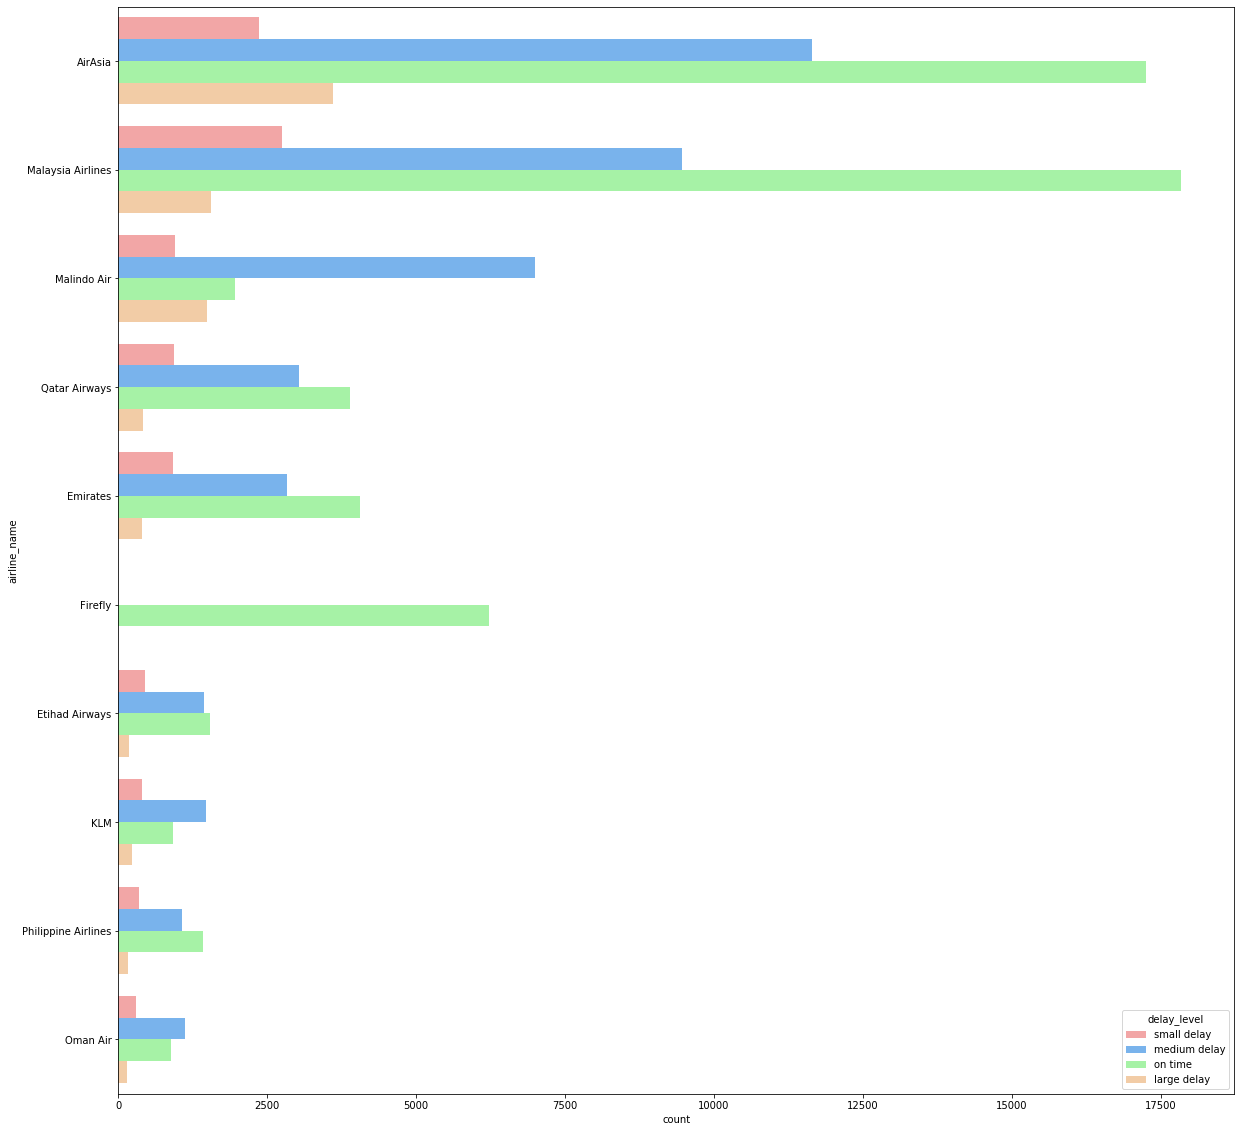

In [64]:
fig = plt.figure(1, figsize=(20, 20))

palette = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

ax = sns.countplot(y="airline_name", hue='delay_level', palette=palette, data=df[df["airline_name"].isin(top_10_airline_counts)], order = top_10_airline_counts)
plt.show()

### Count No. of Airplanes in a Terminal on Specific Date

In [65]:
cnt_by_airport_date_df = df.groupby(["scheduled_departure_date", "departure_airport_code"]).count()[["id"]].reset_index().rename(columns={"id": "cnt_by_airport_date"})

In [66]:
df = pd.merge(df, cnt_by_airport_date_df,  how='left', left_on=["scheduled_departure_date", "departure_airport_code"], right_on=["scheduled_departure_date", "departure_airport_code"])

In [67]:
df.sample()

,id,number,airline,airline_name,scheduled_departure_time,scheduled_arrival_time,departure_airport_city,departure_airport_code,departure_airport_country,departure_airport_gate,departure_airport_name,departure_airport_region,departure_airport_terminal,departure_airport_timezone,arrival_airport_city,arrival_airport_code,arrival_airport_country,arrival_airport_gate,arrival_airport_name,arrival_airport_region,arrival_airport_terminal,arrival_airport_timezone,flight_equipment_iata,flight_equipment_name,flight_duration,delay,flag_test,scheduled_flight_duration,distance,scheduled_flight_duration_h,flight_velocity,flag_faster_flight,scheduled_departure_day,scheduled_departure_weekend_flag,scheduled_departure_hour,scheduled_departure_pod,scheduled_departure_date,scheduled_departure_holiday_flag,scheduled_departure_min_1_holiday_flag,flag_delay,delay_level,cnt_by_airport_date
785,805,EY411,EY,Etihad Airways,2018-10-06 11:45:00,2018-10-06 19:00:00,Kuala Lumpur,KUL,MY,C12,Kuala Lumpur International Airport,Asia,M,Asia/Kuala_Lumpur,Abu Dhabi,AUH,AE,NaN,Abu Dhabi International Airport,Middle East,T1,Asia/Dubai,332,Airbus A330-200,7h 15m,19,0,435.0,5590.45,7.25,771.096552,0.0,Saturday,1,11,Morning,2018-10-06,1,0,1,medium delay,993


### Count No. of Airplanes in a Terminal on Specific Hour

In [68]:
cnt_by_airport_hour_df = df.groupby(["departure_airport_code", "scheduled_departure_hour"]).count()[["id"]].reset_index().rename(columns={"id": "cnt_by_airport_hour"})

In [69]:
df = pd.merge(df, cnt_by_airport_hour_df,  how='left', left_on=["scheduled_departure_hour", "departure_airport_code"], right_on=["scheduled_departure_hour", "departure_airport_code"])

In [70]:
df.sample()

,id,number,airline,airline_name,scheduled_departure_time,scheduled_arrival_time,departure_airport_city,departure_airport_code,departure_airport_country,departure_airport_gate,departure_airport_name,departure_airport_region,departure_airport_terminal,departure_airport_timezone,arrival_airport_city,arrival_airport_code,arrival_airport_country,arrival_airport_gate,arrival_airport_name,arrival_airport_region,arrival_airport_terminal,arrival_airport_timezone,flight_equipment_iata,flight_equipment_name,flight_duration,delay,flag_test,scheduled_flight_duration,distance,scheduled_flight_duration_h,flight_velocity,flag_faster_flight,scheduled_departure_day,scheduled_departure_weekend_flag,scheduled_departure_hour,scheduled_departure_pod,scheduled_departure_date,scheduled_departure_holiday_flag,scheduled_departure_min_1_holiday_flag,flag_delay,delay_level,cnt_by_airport_date,cnt_by_airport_hour
3614,3657,MI8397,MI,SilkAir,2018-10-07 12:00:00,2018-10-07 14:00:00,Langkawi,LGK,MY,NaN,Langkawi International Airport,Asia,NaN,Asia/Kuala_Lumpur,Singapore,SIN,SG,NaN,Changi International Airport,Asia,2,Asia/Singapore,32S,Airbus A318 / A319 / A320 / A321,2h,0,0,120.0,727.56,2.0,363.78,1.0,Sunday,1,12,Morning,2018-10-07,0,1,0,on time,65,178


### Get Wake Category from Flight_Equipment_IATA
The wake category is obtained from the [Flugzeuginfo.net](http://www.flugzeuginfo.net/table_accodes_iata_en.php). Wake turbulence is a disturbance in the atmosphere that forms behind an aircraft as it passes through the air. It includes various components, the most important of which are wingtip vortices and jetwash. ICAO mandates the Wake turbulence categories based upon the Maximum Takeoff Weight (MTOW) of the aircraft. The FAA uses a similar system, though with different weights (Wikipedia).

| ICAO Category | MTOW                                          |
|---------------|-----------------------------------------------|
| Light (L)     | x <= 7,000 kilograms (15,000 lb)              |
| Medium (M)    | 7,000 kg < x < 136,000 kilograms (300,000 lb) |
| Heavy (H)     | 136,000 kg <= x                               |
| Super (J)     | Airbus A380                                   |

In [71]:
flightment_iata_df = pd.read_csv("../data/flight/flightment_iata.csv")

In [72]:
df = pd.merge(df, flightment_iata_df[["IATA", "Wake"]], how='left', left_on="flight_equipment_iata", right_on="IATA")

### Get the Weather Data

#### Clean the Weather Data

In [73]:
df["departure_airport_city"].unique()

array(['Kuala Lumpur', 'Kota Kinabalu', 'Sandakan', 'Kudat', 'Miri',
       'Labuan', 'Penang', 'Kuching', 'Bintulu', 'Johor Bharu',
       'Langkawi', 'Sibu', 'Marudi', 'Kota Bharu', 'Lawas', 'Mulu'],
      dtype=object)

In [74]:
weather_data_df = pd.read_csv("../data/flight/weather_data/labuan.csv", index_col=False, sep=";")

In [75]:
weather_data_df.sample()

,Local time in Labuan (airport),T,Po,P,Pa,U,DD,Ff,ff10,ff3,N,WW,W1,W2,Tn,Tx,Cl,Nh,H,Cm,Ch,VV,Td,RRR,tR,E,Tg,E',sss
7,31.12.2018 02:00,26.6,754.3,756.8,-1.2,87,Wind blowing from the south-southwest,3,NaN,NaN,"90 or more, but not 100%","Lightning visible, no thunder heard.",Cloud covering more than 1/2 of the sky throug...,Cloud covering more than 1/2 of the sky throug...,NaN,NaN,"Cumulonimbus capillatus (often with an anvil),...",50%.,300-600,Altocumulus translucidus or opacus in two or m...,Cirrostratus not progressively invading the sk...,15.0,24.3,No precipitation,6.0,NaN,NaN,NaN,NaN


In [76]:
weather_data_df["date"] = weather_data_df.iloc[:,0].str.split().str[0].str.split(".").apply(lambda x: np.array(x)[[2, 1, 0]]).str.join("-")
weather_data_df["time"] = weather_data_df.iloc[:,0].str.split().str[1].str.split(":").str[0]

In [77]:
weather_data_df = weather_data_df[["date", "time", "T", "Po", "U", "DD", "Ff", "N", "WW", "Cl", "Nh", "H", "VV"]]

In [78]:
weather_data_df["city"] = "Labuan"

In [81]:
# weather_data_comp_df = weather_data_df.copy()

In [82]:
# weather_data_comp_df = weather_data_comp_df.append(weather_data_df)

In [83]:
# weather_data_comp_df.to_csv("weather_data_comp.csv", index=False, encoding = "utf-8")

In [94]:
weather_data_comp_df = pd.read_csv("weather_data_comp.csv")

### Find the Closest Time and Date to Weather

In [95]:
weather_data_comp_df["time"].unique()

array([23, 20, 17, 14, 11,  8,  5,  2], dtype=int64)

In [96]:
df["scheduled_departure_hour"].unique()

array([22, 23,  6,  0,  1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 21, 19, 20], dtype=int64)

In [97]:
def get_closest_weather_time(time):
    if time in [1, 2, 3]:
        return "02"
    elif time in [4, 5, 6]:
        return "05"
    elif time in [7, 8, 9]:
        return "08"
    elif time in [10, 11, 12]:
        return "11"
    elif time in [13, 14, 15]:
        return "14"
    elif time in [16, 17, 18]:
        return "17"
    elif time in [19, 20, 21]:
        return "20"
    elif time in [22, 23, 0]:
        return "23"

In [98]:
df["closest_weather_time"] = df["scheduled_departure_hour"].apply(get_closest_weather_time)

#### Combine Weather Data with the Flight Data

In [99]:
df.sample()

,id,number,airline,airline_name,scheduled_departure_time,scheduled_arrival_time,departure_airport_city,departure_airport_code,departure_airport_country,departure_airport_gate,departure_airport_name,departure_airport_region,departure_airport_terminal,departure_airport_timezone,arrival_airport_city,arrival_airport_code,arrival_airport_country,arrival_airport_gate,arrival_airport_name,arrival_airport_region,arrival_airport_terminal,arrival_airport_timezone,flight_equipment_iata,flight_equipment_name,flight_duration,...,scheduled_departure_pod,scheduled_departure_date,scheduled_departure_holiday_flag,scheduled_departure_min_1_holiday_flag,flag_delay,delay_level,cnt_by_airport_date,cnt_by_airport_hour,IATA,Wake,closest_weather_time,date,time,T,Po,U,DD,Ff,N,WW,Cl,Nh,H,VV,city
119855,529522,AK122,AK,AirAsia,2018-12-05 08:30:00,2018-12-05 12:45:00,Kuala Lumpur,KUL,MY,P11,Kuala Lumpur International Airport,Asia,2,Asia/Kuala_Lumpur,Shenzhen,SZX,CN,NaN,Shenzhen Bao'an International Airport,Asia,T3,Asia/Shanghai,32S,Airbus A318 / A319 / A320 / A321,4h 7m,...,Early Morning,2018-12-05,0,0,1,medium delay,1177,4091,NaN,NaN,08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [163]:
df = pd.merge(df, weather_data_comp_df, how='left', left_on=["scheduled_departure_date", "closest_weather_time", "departure_airport_city"], right_on=["date", "time", "city"])

In [101]:
merged_weather_df = df[["IATA", "Wake", "T", "Po", "U", "DD", "Ff", "N", "WW", "Cl", "Nh", "H", "VV"]]

In [102]:
df[df["T"].isnull()]["departure_airport_city"].unique()

array(['Kuala Lumpur', 'Kota Kinabalu', 'Sandakan', 'Kudat', 'Miri',
       'Penang', 'Kuching', 'Bintulu', 'Johor Bharu', 'Langkawi', 'Sibu',
       'Marudi', 'Kota Bharu', 'Lawas', 'Mulu'], dtype=object)

In [103]:
# gives some infos on columns types and number of null values
df_info = pd.DataFrame(merged_weather_df.dtypes).rename(columns={0:'data_type'})
df_info["#_unique"] = merged_weather_df.nunique()
df_info["#_nan"] = merged_weather_df.isnull().sum().astype(int)
df_info["%_nan"] = merged_weather_df.isnull().sum()/merged_weather_df.shape[0]*100

df_info.sort_values(by="#_unique", ascending=False)

,data_type,#_unique,#_nan,%_nan
T,float64,70,152341,99.628537
Po,float64,52,152341,99.628537
IATA,object,44,44602,29.168983
U,float64,36,152341,99.628537
DD,object,16,152341,99.628537
WW,object,14,152341,99.628537
VV,float64,12,152341,99.628537
Ff,float64,6,152341,99.628537
Nh,object,6,152347,99.632461
Wake,object,3,44602,29.168983


In [104]:
df.sample()

,id,number,airline,airline_name,scheduled_departure_time,scheduled_arrival_time,departure_airport_city,departure_airport_code,departure_airport_country,departure_airport_gate,departure_airport_name,departure_airport_region,departure_airport_terminal,departure_airport_timezone,arrival_airport_city,arrival_airport_code,arrival_airport_country,arrival_airport_gate,arrival_airport_name,arrival_airport_region,arrival_airport_terminal,arrival_airport_timezone,flight_equipment_iata,flight_equipment_name,flight_duration,...,scheduled_departure_pod,scheduled_departure_date,scheduled_departure_holiday_flag,scheduled_departure_min_1_holiday_flag,flag_delay,delay_level,cnt_by_airport_date,cnt_by_airport_hour,IATA,Wake,closest_weather_time,date,time,T,Po,U,DD,Ff,N,WW,Cl,Nh,H,VV,city
77150,296762,RJ181,RJ,Royal Jordanian,2018-11-14 14:20:00,2018-11-14 16:20:00,Kuala Lumpur,KUL,MY,C1,Kuala Lumpur International Airport,Asia,M,Asia/Kuala_Lumpur,Bangkok,BKK,TH,NaN,Suvarnabhumi Airport,Asia,NaN,Asia/Bangkok,788,Boeing 787-8,2h,...,Noon,2018-11-14,0,0,1,small delay,1132,3650,788,H,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning

### Drop Possibly Unused Features

The feature below are dropped based on these criteria:
1. Categorical features which have plenty number of unique values (e.g. `scheduled_arrival_time`)
2. Categorical features with similar number of unique values (e.g. `arrival_airport_name` and `arrival_airport_code` are pretty similar, one of them needs to be dropped)
3. Features which have more than ~40% of missing data
4. Features with only 1 unique value


In [107]:
df = df.drop([
    "id", 
    "scheduled_arrival_time", 
    "scheduled_departure_time", 
    "flight_duration",
    "arrival_airport_gate",
    "departure_airport_gate",
    "arrival_airport_name",
    "arrival_airport_city",
    "airline",
    "flight_equipment_name",
    "arrival_airport_timezone",
    "arrival_airport_country",
    "arrival_airport_terminal",
    "departure_airport_name",
    "departure_airport_city",
    "departure_airport_terminal",
    "arrival_airport_region",
    "departure_airport_region",
    "departure_airport_country",
    "departure_airport_timezone"
], axis=1)

In [108]:
df.head()

,number,airline_name,departure_airport_code,arrival_airport_code,flight_equipment_iata,delay,flag_test,scheduled_flight_duration,distance,scheduled_flight_duration_h,flight_velocity,flag_faster_flight,scheduled_departure_day,scheduled_departure_weekend_flag,scheduled_departure_hour,scheduled_departure_pod,scheduled_departure_date,scheduled_departure_holiday_flag,scheduled_departure_min_1_holiday_flag,flag_delay,delay_level,cnt_by_airport_date,cnt_by_airport_hour,IATA,Wake,closest_weather_time,date,time,T,Po,U,DD,Ff,N,WW,Cl,Nh,H,VV,city
0,AK6430,AirAsia,KUL,KBR,32S,2,0,65.0,385.98,1.083333,356.289231,0.0,Friday,0,22,Night,2018-10-05,0,1,1,small delay,1055,2174,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ID*7164,Batik Air,KUL,CGK,32S,8,0,115.0,1129.47,1.916667,589.288696,0.0,Friday,0,22,Night,2018-10-05,0,1,1,medium delay,1055,2174,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MXD9116,Malindo Air,KUL,CGK,32S,8,0,115.0,1129.47,1.916667,589.288696,0.0,Friday,0,22,Night,2018-10-05,0,1,1,medium delay,1055,2174,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AK5198,AirAsia,KUL,SDK,32S,0,0,175.0,1846.94,2.916667,633.236571,1.0,Friday,0,22,Night,2018-10-05,0,1,0,on time,1055,2174,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AK516,AirAsia,KUL,HAN,32S,0,0,195.0,2102.37,3.250000,646.883077,0.0,Friday,0,22,Night,2018-10-05,0,1,0,on time,1055,2174,NaN,NaN,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Drop Missing Values

In [109]:
df = df.dropna()

In [110]:
print(f"After missing values are removed the total number of rows become {df.shape[0]}")

After missing values are removed the total number of rows become 562


### Drop Outliers

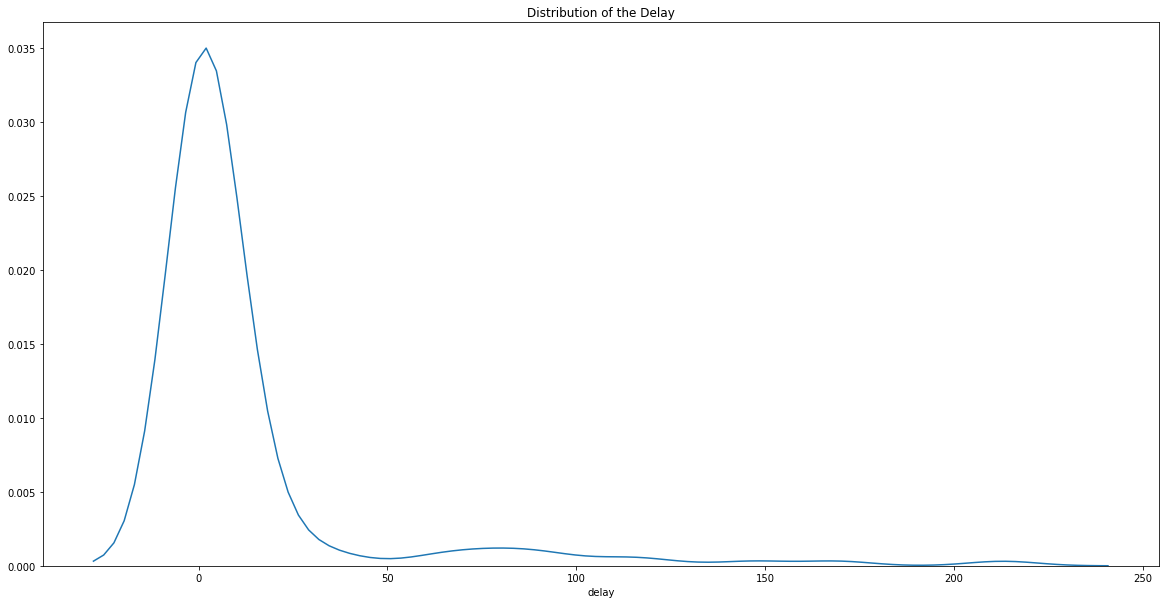

In [111]:
plt.figure(figsize=[20, 10])
sns.distplot(df["delay"], hist=False)
plt.title("Distribution of the Delay")
plt.show()

In [113]:
print(f"The total number of rows before the deletion of the outliers based on the column delay is {df.shape[0]}")

The total number of rows before the deletion of the outliers based on the column delay is 562


In [114]:
q1 = df["delay"].quantile(0.25)
q3 = df["delay"].quantile(0.75)

iqr = q3 - q1

In [115]:
df = df[~(df["delay"] > (q3 + 6 * iqr))]

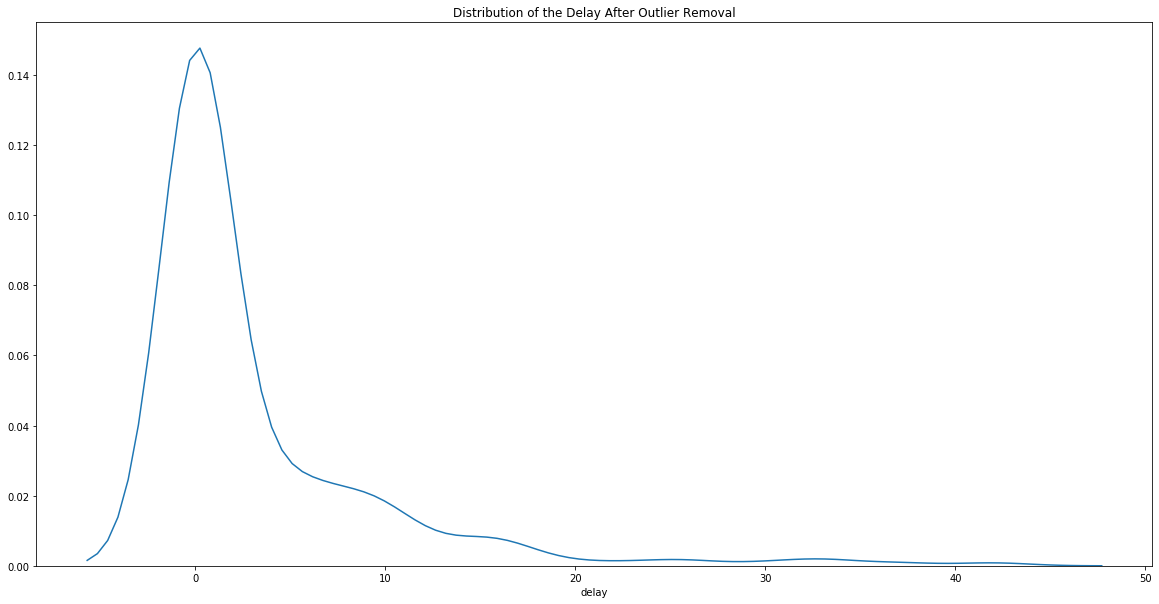

In [116]:
plt.figure(figsize=[20, 10])
sns.distplot(df["delay"], hist=False)
plt.title("Distribution of the Delay After Outlier Removal")
plt.show()

In [117]:
print(f"The total number of rows before the deletion of the outliers based on the column delay is {df.shape[0]}")

The total number of rows before the deletion of the outliers based on the column delay is 514


In [118]:
df_test = df.copy()
df_test = df_test[df_test["flag_test"] == 1]

df = df[df["flag_test"] == 0].drop("flag_test", axis=1)

### Correlation Between Numerical Features

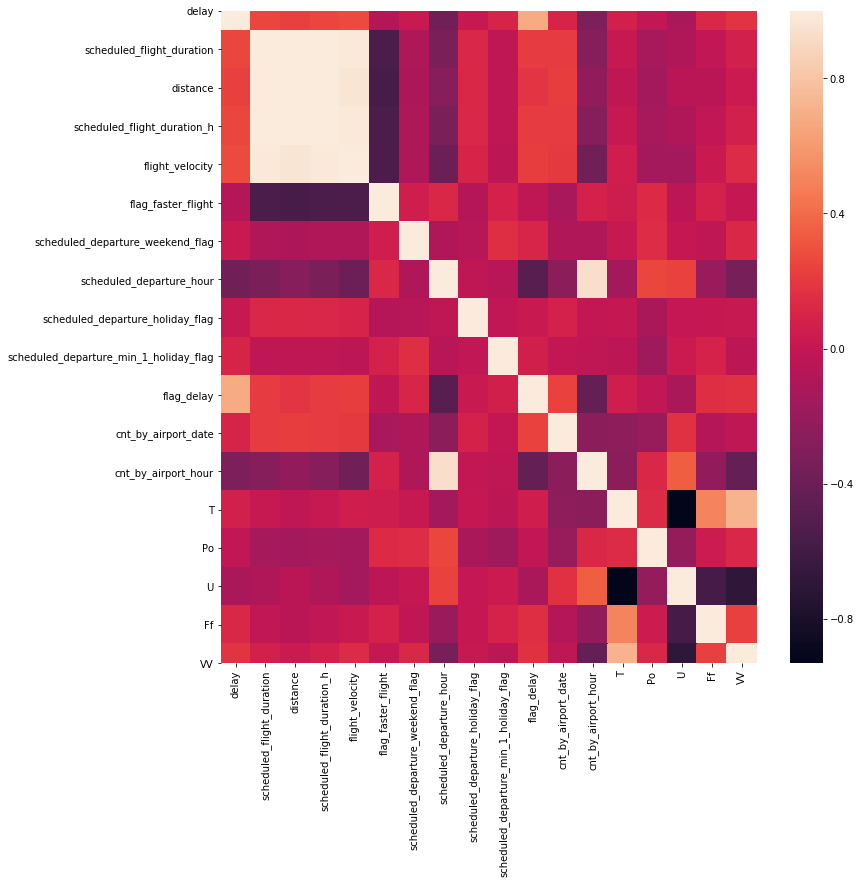

In [119]:
plt.figure(figsize=[12, 12])
sns.heatmap(df.corr())
plt.show()

### Recommendation for the Passengers

In [120]:
delay_by_features = ["airline_name", 
                     "scheduled_departure_pod", 
                     "scheduled_departure_hour", 
                     "scheduled_departure_holiday_flag", 
                     "scheduled_departure_day",
                    "arrival_airport_code",
                     "departure_airport_code",
                    "number"]
delay_bys = {}

for delay_by_feature in delay_by_features:
    cnt_delay_by_df = df.groupby(delay_by_feature).sum()["flag_delay"].reset_index().rename(columns={"flag_delay": "cnt_delay"})
    obs_delay_by_df = df.groupby(delay_by_feature).count()["flag_delay"].reset_index().rename(columns={"flag_delay": "obs_delay"})

    delay_by_df = pd.merge(cnt_delay_by_df, obs_delay_by_df,  how='left', left_on=[delay_by_feature], right_on=[delay_by_feature])
    delay_by_df["%_delay"] = delay_by_df["cnt_delay"] / delay_by_df["obs_delay"]
    
    delay_bys[delay_by_feature] = delay_by_df.sort_values(by="%_delay")

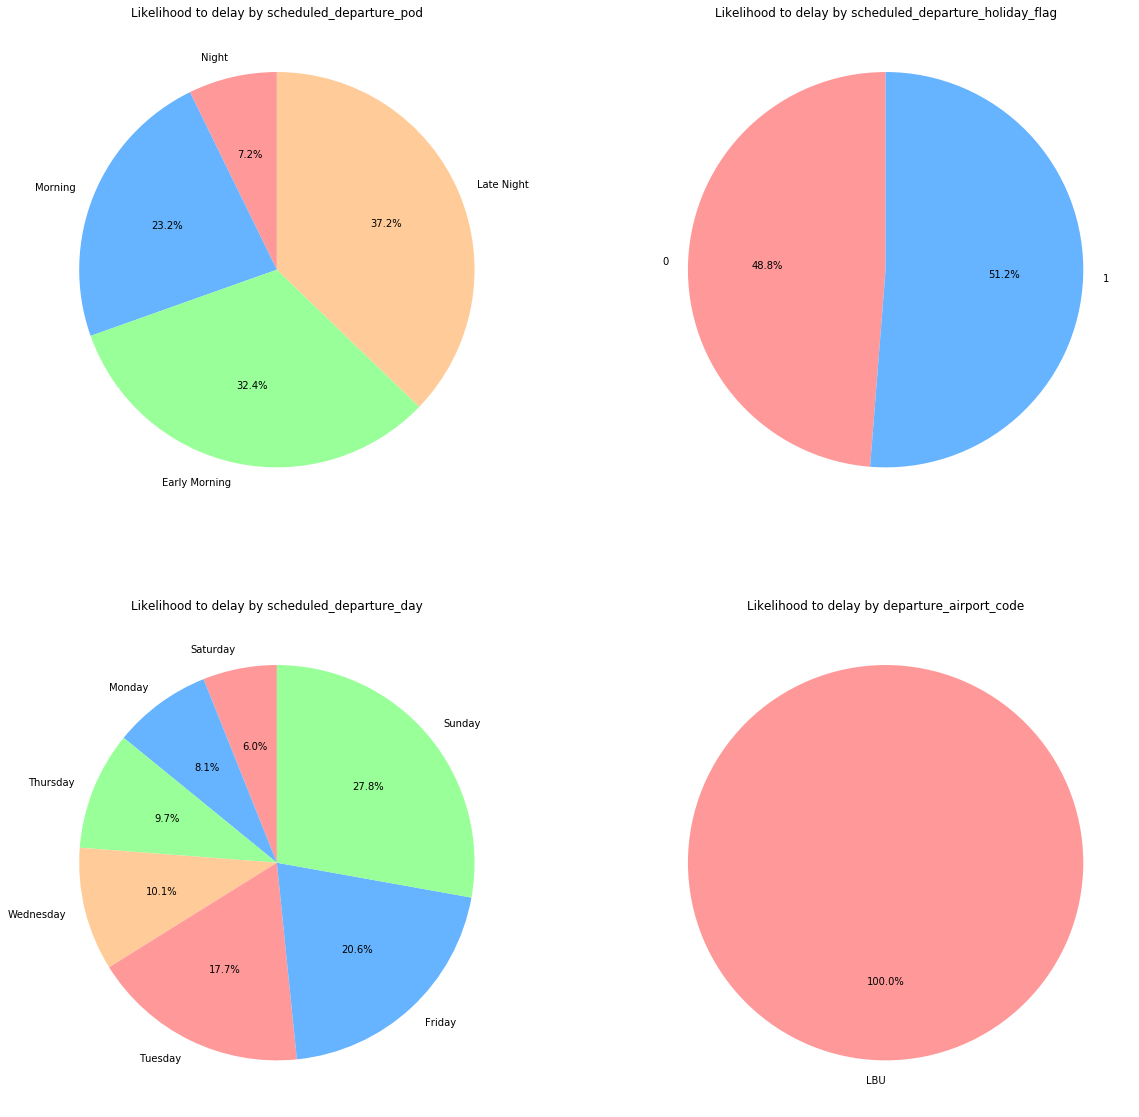

In [121]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']


i, j = 0, 0
for col in ["scheduled_departure_pod", "scheduled_departure_holiday_flag", "scheduled_departure_day", "departure_airport_code"]:
    labels = list(delay_bys[col][col])
    sizes = list(round(delay_bys[col]["%_delay"] * 100))
    
    axs[i, j].pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
    axs[i, j].set_title(f"Likelihood to delay by {col}")
    j += 1
    
    if j % 2 == 0:
        j = 0
        i += 1
        
plt.show()

Looking at the pie charts above we can conclude these recommendations for the passengers:
1. Travelling in the night (9pm - 3am) has a lower likelihood to delay compared to traveling in the noon (12pm - 4pm)
2. Travelling in during the d-day of holiday has lower chance to delay compared to other normal days
3. There's no really significant difference between travelling on weekdays or on weekends
4. Travelling from Sultan Abdul Aziz Shah Airport (SZB) has lower chance to delay compared than the rest airport

In [122]:
delay_bys["airline_name"].head()

,airline_name,cnt_delay,obs_delay,%_delay
0,Malaysia Airlines,152,384,0.395833


Travelling using Firefly is very recommended since it has zero delays even after the 4,5k flights in the month

In [123]:
delay_bys["arrival_airport_code"].head()

,arrival_airport_code,cnt_delay,obs_delay,%_delay
2,KCH,0,2,0.000000
0,BKI,52,216,0.240741
3,MYY,90,154,0.584416
1,HAN,10,12,0.833333


In [124]:
delay_bys["number"].head()

,number,cnt_delay,obs_delay,%_delay
5,MH6102,0,2,0.000000
0,MH3123,26,172,0.151163
1,MH3217,52,108,0.481481
2,MH3218,26,44,0.590909
3,MH3219,38,46,0.826087


## Linear Regression

In [126]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score

#### Univariate Linear Regression

For the purpose of creating the univariate linear regression, I used the delay as the dependent variable and distance as the independent variable

In [133]:
X = df["distance"].values.reshape(-1,1)
y = df["delay"].values.reshape(-1,1)

reg = LinearRegression()
reg.fit(X, y)
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))

The linear model is: Y = 2.5561 + 0.004457X


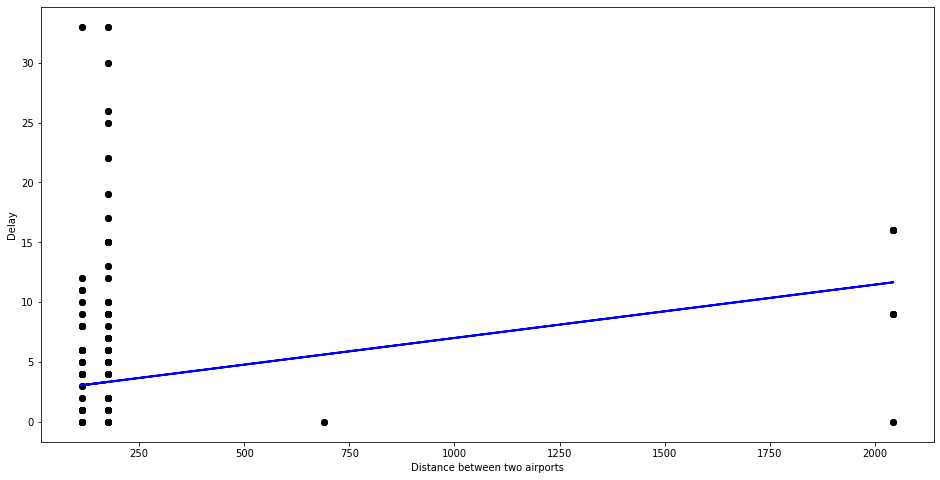

In [134]:
predictions = reg.predict(X)

plt.figure(figsize=(16, 8))
plt.scatter(
    df['distance'],
    df['delay'],
    c='black'
)
plt.plot(
    df['distance'],
    predictions,
    c='blue',
    linewidth=2
)
plt.xlabel("Distance between two airports")
plt.ylabel("Delay")
plt.show()

In [135]:
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, f1_score, auc

In [136]:
r2 = r2_score(y, predictions)
mse = mean_squared_error(y, predictions)

print(f"The R2 Score for the Univariate Linear Regression model is {r2} and the mean-squared error is {mse}")

The R2 Score for the Univariate Linear Regression model is 0.05635493346452569 and the mean-squared error is 37.18387513047858


#### Multivariate Linear Regression

In [144]:
X = df[["flight_velocity", "flag_faster_flight", "scheduled_departure_holiday_flag", "cnt_by_airport_date", "cnt_by_airport_hour", "T"]]
y = df["delay"].values.reshape(-1,1)

reg = LinearRegression()
reg.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [145]:
predictions = reg.predict(X)

In [146]:
r2 = r2_score(y, predictions)
mse = mean_squared_error(y, predictions)

print(f"The R2 Score for the Univariate Linear Regression model is {r2} and the mean-squared error is {mse}")

The R2 Score for the Univariate Linear Regression model is 0.1292515167229401 and the mean-squared error is 34.31142070301985


### Logistic Regression

In [147]:
X = df["distance"].values.reshape(-1,1)
y = df["flag_delay"].values.reshape(-1,1)

In [148]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

In [149]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [150]:
y_pred = lr.predict(X_val)

The confusion matrix, AUC and F1Score for the logistic regression model

In [151]:
print(f"The confusion matrix is as follow {confusion_matrix(y_val, y_pred)}")
print(f"The F1 Score is {f1_score(y_val, y_pred)}")

The confusion matrix is as follow [[58  0]
 [35  3]]
The F1 Score is 0.14634146341463414


In [155]:
from scipy.special import expit

df = pd.DataFrame({'X': X_val[:,0], 'y': y_val})
df = df.sort_values(by='X')

sigmoid_function = expit(df['X'] * lr.coef_[0][0] + lr.intercept_[0]).ravel()
plt.figure(figsize=(16, 8))

plt.plot(df['X'], sigmoid_function)
plt.scatter(df['X'], df['y'], c=df['y'])
plt.show()

#### Decision Tree

In [156]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO 


In [157]:
X = df[["distance", "scheduled_departure_weekend_flag", "scheduled_departure_holiday_flag"]]
y = df["delay"]

In [158]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=1)

In [159]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [160]:
y_pred = dt.predict(X_val)

In [162]:
print(f"The confusion matrix is as follow {confusion_matrix(y_val, y_pred)}")
print(f"The F1 Score is {f1_score(y_val, y_pred)}")
print(f"The AUC is {auc(y_val, y_pred)}")